### Online store

Today we will analyze online sales data to understand market and customer trends. We work for an imaginary online store in the US. The goal is to extract insights from the dataset online_sales in order to give recommendations to the company on new effective marketing campaigns.


Load the dataset, understand the data, make visualizations, clean the data (think which transactions are counted as valid to your project) and make all the necessary data transformation and aggregations to answer the following questions (communicate your results with visualizations):

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.precision', 2)

In [15]:
df = pd.read_csv('csv/online_sales.csv')

/tmp/ipykernel_9358/2166572984.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv/online_sales.csv')


I got a warning in the first column which I am curious to inspect

In [16]:
df.iloc[:5,0]

0    100354678
1    100354678
2    100354680
3    100354680
4    100367357
Name: order_id, dtype: object

it is an `order_id` column and it seems to contain digits only. I am going to examine if there are any values that don't adhere to a strictly numeric pattern. To achieve this I am going to use regex

In [17]:
df = pd.read_csv('csv/online_sales.csv', usecols=[0], dtype=str)
non_numeric = df[~df.iloc[:, 0].str.match(r'^\d+$', na=False)]
print(non_numeric.head())

           order_id
206148  100468520-1
272777  100542843-1
275274  100546199-1
275275  100546199-1
277993  100549449-1


As we can see, some of them have a non-numeric format which is ok, because I want my order_id to be strings (objects).  
I will be loading that particular column as a string

In [18]:
# No warnings this time
df = pd.read_csv('csv/online_sales.csv', dtype={'order_id': str})

Now I will inspect the columns for types and null values

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286392 entries, 0 to 286391
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          286392 non-null  object 
 1   order_date        286392 non-null  object 
 2   status            286392 non-null  object 
 3   item_id           286392 non-null  float64
 4   sku               286392 non-null  object 
 5   qty_ordered       286392 non-null  float64
 6   price             286392 non-null  float64
 7   value             286392 non-null  float64
 8   discount_amount   286392 non-null  float64
 9   total             286392 non-null  float64
 10  category          286392 non-null  object 
 11  payment_method    286392 non-null  object 
 12  bi_st             286392 non-null  object 
 13  cust_id           286392 non-null  float64
 14  year              286392 non-null  int64  
 15  month             286392 non-null  object 
 16  ref_num           28

In [20]:
df.isna().sum().sum()  # just to verify

0

by looking at the column names, it seems like a typical denormalized sales dataset, probably a result of join of a sales table, a customer table and an item table (inventory table entries do not seem to be present here).  
Rows represent lines in an order invoice. As a result the order_id fields will have duplicates.

Before moving on let's convert a few columns to strings, as they do not make sense as integers.

In [21]:
df[['item_id', 'cust_id', 'Zip',
    'ref_num']] = df[['order_id', 'cust_id', 'Zip',
                      'ref_num']].astype(str)

And let's also remove the canceled and refunded transactions (hint from solutions)

In [22]:
df['status'].unique()

array(['received', 'complete', 'order_refunded', 'canceled', 'refund',
       'cod', 'paid', 'processing', 'closed', 'pending', 'pending_paypal',
       'payment_review', 'holded'], dtype=object)

In [23]:
statuses_to_drop = ['order_refunded', 'canceled', 'refund']
df = df[~df['status'].isin(statuses_to_drop)]
df.sample(20)

,order_id,order_date,status,item_id,sku,qty_ordered,price,value,discount_amount,total,...,Phone No.,Place Name,County,City,State,Zip,Region,User Name,Discount_Percent,age_group
205782,100528837,2021-06-17,received,100528837,COMSEA5A7E037FDA38D,3.0,605.3,1210.6,258.95,951.65,...,339-597-9562,Southampton,Hampshire,Southampton,MA,1073,Northeast,gahardy,21.39,75+
27071,100530642,2021-06-19,received,100530642,MATINF5A81677F7A0AE,2.0,1379.9,1379.9,199.19,1180.71,...,304-360-9516,Birch River,Nicholas,Birch River,WV,26610,South,wbhinojos,14.44,55-64
80182,100391576,2020-12-21,complete,100391576,MATINF59C9002EA6AF0,2.0,950.0,950.0,0.00,950.00,...,316-510-0449,Whitewater,Butler,Whitewater,KS,67154,Midwest,lchawes,0.00,65-74
95821,100387978,2020-12-20,complete,100387978,CLO59F6F89956882,3.0,21.9,43.8,8.76,35.04,...,605-977-6962,Lesterville,Yankton,Lesterville,SD,57040,Midwest,mgcuadrado,20.00,65-74
158654,100440549,2021-01-29,complete,100440549,SOGMAY5A2F7FD441F9A,2.0,23.0,23.0,0.00,23.00,...,212-627-3243,Elmira,Chemung,Elmira,NY,14904,Northeast,dohemphill,0.00,25-34
174208,100445497,2021-02-15,received,100445497,BRA5A5726A16F93D,3.0,26.4,52.8,0.00,52.80,...,239-423-0531,Lehigh Acres,Lee,Lehigh Acres,FL,33970,South,mxcopenhaver,0.00,35-44
234739,100500799,2021-04-30,received,100500799,OTHPCB5AB351E8F25CB,6.0,500.0,2500.0,0.00,2500.00,...,252-312-5042,Ellenboro,Rutherford,Ellenboro,NC,28040,South,fmwayne,0.00,18-24
108525,100401536,2020-12-23,complete,100401536,APPORI5A05B232641E7,2.0,2552.1,2552.1,330.00,2222.10,...,212-552-2586,East Meredith,Delaware,East Meredith,NY,13757,Northeast,dkbolles,12.93,35-44
196302,100556886,2021-09-14,received,100556886,MATAPP59AD3CFE4A7CA,3.0,4445.9,8891.8,0.00,8891.80,...,304-839-9761,Sod,Lincoln,Sod,WV,25564,South,eapero,0.00,18-24
85057,100382737,2020-12-20,complete,100382737,MATINF59BAB37E3AB89,2.0,1387.9,1387.9,138.79,1249.11,...,252-716-8662,Charlotte,Mecklenburg,Charlotte,NC,28213,South,jgbengtson,10.00,55-64


##### Which category gives the highest sales?

In my opinion and contraty to the solution this is about the revenue and not the rows of each category as the solution suggests.

In [24]:

total_sales_per_category = df.groupby('category')['total'].sum()
total_sales_per_category  / 10_000

category
Appliances            1432.03
Beauty & Grooming      147.95
Books                    1.48
Computing              296.14
Entertainment         1281.56
Health & Sports         59.03
Home & Living          102.65
Kids & Baby             49.90
Men's Fashion          235.32
Mobiles & Tablets     3882.83
Others                 472.16
School & Education       5.44
Soghaat                 28.83
Superstore             163.39
Women's Fashion        358.66
Name: total, dtype: float64

In [25]:
total_sales_per_category.idxmax()

'Mobiles & Tablets'

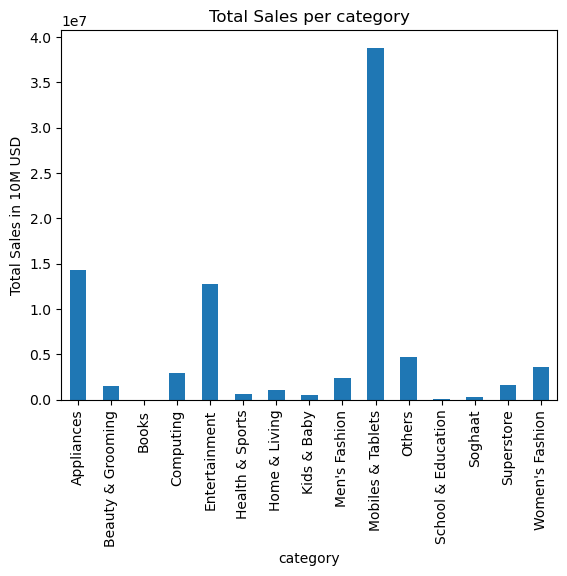

In [27]:
total_sales_per_category.plot(kind='bar', title='Total Sales per category')
plt.ylabel('Total Sales in 10M USD')
plt.show()

##### Which categories are bought the most from men and which from women?

To answer this I will only look at the count of orders for each category, without taking into acount the quantity of each purchase. The reason for doing this, is the fact that cheaper items like book are far more likely to show multiple items per order, and that would lead to bias towards such items.

In [28]:
categories_per_gender = pd.crosstab(df['category'], df['Gender'])
categories_per_gender

Gender,F,M
category,,
Appliances,8307,8398
Beauty & Grooming,5387,5432
Books,247,324
Computing,1753,1901
Entertainment,4295,4232
Health & Sports,1821,3928
Home & Living,4233,4111
Kids & Baby,1895,1834
Men's Fashion,10812,11339


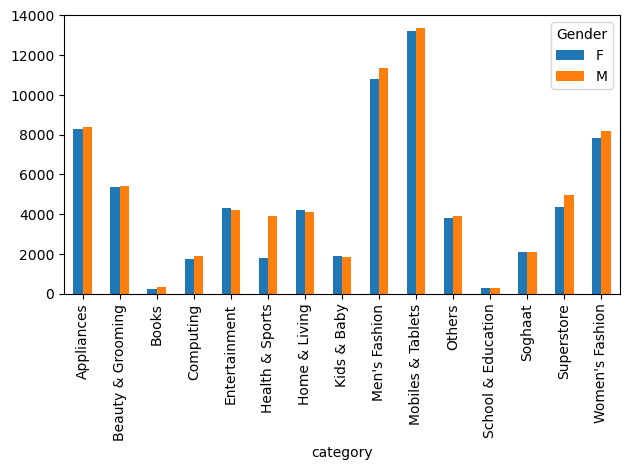

In [29]:
categories_per_gender.plot(kind='bar')
plt.tight_layout()
plt.show()

##### Which month of the year has the highest revenue? Can you guess why?  

We need to retrieve the month of the order first, as the month field contains month and year combined. I first need to convert order_date to datetime and then create a column called order_month

In [32]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.month
total_per_month = df.groupby('order_month')['total'].sum()
# The solution favors the sort_values method, but I personally prefer the months to be appear in chronological order.
total_per_month.idxmax()

12

December is the highest revenue month and it makes a lot of sense considering the Christmas holidays. Let's see it in a bar chart too.

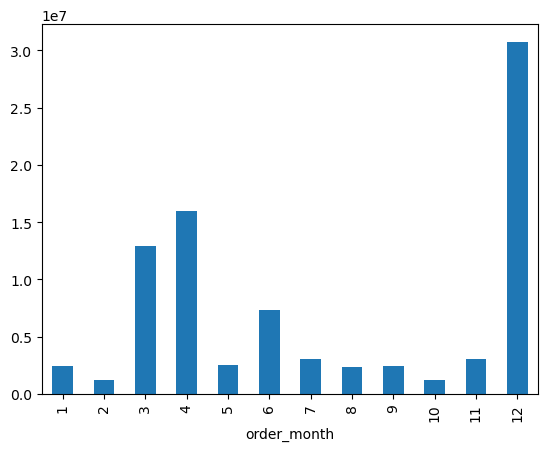

In [33]:
total_per_month.plot(kind='bar')
plt.show()

##### Which are the top five states that generate the highest revenue?  

In [34]:
top_five_states_revenue = df.groupby('State')['total'].sum().sort_values().tail(5)[::-1]
top_five_states_revenue

State
CA    6.14e+06
TX    5.37e+06
NY    4.56e+06
PA    4.14e+06
FL    3.34e+06
Name: total, dtype: float64

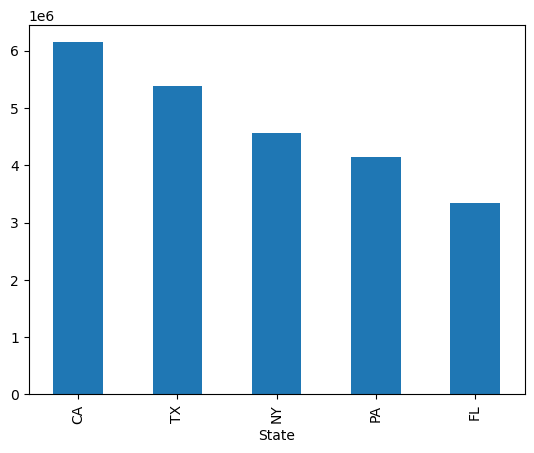

In [35]:
top_five_states_revenue.plot(kind='bar')
plt.show()

##### Which category is the highest in terms of revenue for each state? (Hard!)  

In [38]:
category_state_sales = pd.pivot_table(data=df, values='total', columns='State', index='category', aggfunc='sum')
category_state_sales

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
category,,,,,,,,,,,,,,,,,,,,,
Appliances,100267.78,257229.18,214547.44,182124.79,1.14e+06,239969.99,113867.53,85709.71,57500.75,6.80e+05,...,126646.51,271900.25,9.23e+05,128219.46,4.75e+05,106010.00,166626.35,240503.35,296667.32,52253.95
Beauty & Grooming,14759.31,31847.27,31575.59,28540.61,8.69e+04,29162.57,25516.81,7628.47,1867.36,5.29e+04,...,13035.04,26092.72,8.63e+04,16196.30,4.05e+04,14217.56,17352.89,29267.40,33039.12,7792.55
Books,94.90,134.90,39.40,169.10,1.28e+03,500.61,139.50,19.80,0.00,5.87e+02,...,26.50,0.00,1.14e+03,70.90,2.99e+01,159.40,0.00,30.00,654.60,NaN
Computing,6348.50,57141.51,35602.20,81557.39,1.72e+05,47062.88,20729.31,50922.35,753.70,1.77e+05,...,38261.69,31383.51,1.40e+05,61837.88,1.27e+05,72447.35,17358.45,93214.91,23026.86,2443.93
Entertainment,174229.60,211512.98,122930.11,157236.92,1.08e+06,167037.62,140731.83,64076.70,21476.09,5.71e+05,...,98214.10,277084.48,8.00e+05,212581.94,4.61e+05,50872.88,226336.30,257147.08,346599.80,52992.54
Health & Sports,2149.80,8639.25,4611.16,5620.79,1.89e+04,10431.82,4840.86,6629.84,1116.80,2.26e+04,...,3735.18,6044.47,3.78e+04,3357.00,2.57e+04,1725.08,5366.37,11185.17,9155.85,10610.81
Home & Living,13106.76,29127.13,21112.27,8890.42,7.68e+04,9318.92,12838.16,5677.36,781.90,2.64e+04,...,7464.67,8547.48,6.29e+04,4112.55,3.59e+04,12799.56,19892.29,20047.16,16454.20,7560.03
Kids & Baby,4655.27,4481.43,4722.71,3493.73,4.57e+04,4697.05,7040.12,1631.46,1558.42,1.73e+04,...,12816.43,17645.39,2.92e+04,4943.76,1.15e+04,1433.43,6011.14,15662.20,11349.42,418.41
Men's Fashion,17425.49,40242.72,40215.05,33401.28,1.55e+05,37077.35,28699.50,12757.02,5301.06,9.67e+04,...,18266.81,40095.50,1.55e+05,18289.66,6.42e+04,19867.80,28830.00,46577.85,41177.83,10599.27


In [39]:
for state in category_state_sales.columns:
    print(f'in {state}, the {category_state_sales[state].idxmax()} category has the highest sales')

in AK, the Mobiles & Tablets category has the highest sales
in AL, the Mobiles & Tablets category has the highest sales
in AR, the Mobiles & Tablets category has the highest sales
in AZ, the Mobiles & Tablets category has the highest sales
in CA, the Mobiles & Tablets category has the highest sales
in CO, the Mobiles & Tablets category has the highest sales
in CT, the Mobiles & Tablets category has the highest sales
in DC, the Mobiles & Tablets category has the highest sales
in DE, the Mobiles & Tablets category has the highest sales
in FL, the Mobiles & Tablets category has the highest sales
in GA, the Mobiles & Tablets category has the highest sales
in HI, the Mobiles & Tablets category has the highest sales
in IA, the Mobiles & Tablets category has the highest sales
in ID, the Mobiles & Tablets category has the highest sales
in IL, the Mobiles & Tablets category has the highest sales
in IN, the Mobiles & Tablets category has the highest sales
in KS, the Mobiles & Tablets category ha

##### Which category gives discounts more often? Visualize the top 5 of them.  

In [40]:
df['discount_amount'].sample(20)

221294      0.00
139317      0.00
119169     37.10
85362       0.00
148811      5.49
87429       0.00
141172      0.00
21661     275.00
259737    421.88
176162      0.00
6405       24.74
4634      275.99
113473      0.00
20328      48.00
72241     364.70
117830    203.00
212517      0.00
28181      41.55
225152    319.24
76239       0.00
Name: discount_amount, dtype: float64

In order to tackle this, simply counting the discounted orders (like the solution does) is not indicative because some have a much higher number of orders than others. Instead I want to calculate the ratio of discounted orders over the total orders for each category. To do this I need to first create a boolean category that will indicate if an order was discounted.

In [42]:
df['is_discounted'] = df['discount_amount'].map(bool)
df.sample(100000)

,order_id,order_date,status,item_id,sku,qty_ordered,price,value,discount_amount,total,...,County,City,State,Zip,Region,User Name,Discount_Percent,age_group,order_month,is_discounted
219985,100482377,2021-04-17,complete,100482377,MATINF5A61FBB8820B3,2.0,1368.9,1368.9,236.89,1132.01,...,Price,Catawba,WI,54515,Midwest,nldardar,17.31,35-44,4,True
173510,100444951,2021-02-14,complete,100444951,HASQAR5A53697E3A84A,21.0,4.4,88.0,0.00,88.00,...,Wake,Raleigh,NC,27619,South,edbonanno,0.00,65-74,2,False
42346,100377575,2020-12-13,complete,100377575,HALEMA59BA8E1448F5D,3.0,21.0,42.0,0.00,42.00,...,Findlay,Findlay,IL,62574,Midwest,aasimon,0.00,65-74,12,False
10573,100360142,2020-10-28,complete,100360142,MEFBUY59B7C3E863E7C-41,3.0,39.9,79.8,0.00,79.80,...,Hampshire,Plainfield,MA,1070,Northeast,tnslattery,0.00,18-24,10,False
102114,100391510,2020-12-21,complete,100391510,APPCAN5A0AC3940BA2F,2.0,659.6,659.6,0.00,659.60,...,Auglaize,New Hampshire,OH,45870,Midwest,jeelsner,0.00,18-24,12,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212007,100519187,2021-06-06,complete,100519187,MATSAM5AAB5AEE5DBA7,1.0,2877.0,0.0,0.00,0.00,...,Perry,Corning,OH,43730,Midwest,tiblose,9.00,75+,6,False
79027,100380094,2020-12-17,complete,100380094,SOGCRY59C0BE6F08A55,2.0,12.7,12.7,0.00,12.70,...,Bonneville,Iona,ID,83427,West,jfconey,0.00,18-24,12,False
142511,100417856,2020-12-27,complete,100417856,MEFSHO59CB4D6B35C10-S,2.0,339.8,339.8,0.00,339.80,...,Washington,Sherwood,OR,97140,West,mnmccleery,0.00,18-24,12,False
247743,100539024,2021-07-08,received,100539024,MEFOTT5B0E821C9D8AE-8,2.0,99.9,99.9,0.00,99.90,...,Monterey,Salinas,CA,93915,West,izhouck,0.00,65-74,7,False


Below we can see in percentages, the percentage of orders its category discounts

In [43]:
discount_prc_category = df.groupby('category').apply(lambda group: sum(group['is_discounted']) / group.shape[0]) * 100
discount_prc_category

category
Appliances            50.31
Beauty & Grooming     19.18
Books                  1.58
Computing             44.28
Entertainment         68.68
Health & Sports       11.06
Home & Living         18.48
Kids & Baby           14.08
Men's Fashion         14.75
Mobiles & Tablets     60.88
Others                 2.71
School & Education     7.21
Soghaat               16.44
Superstore            37.38
Women's Fashion       17.81
dtype: float64

And now we will plot the top 5 of them

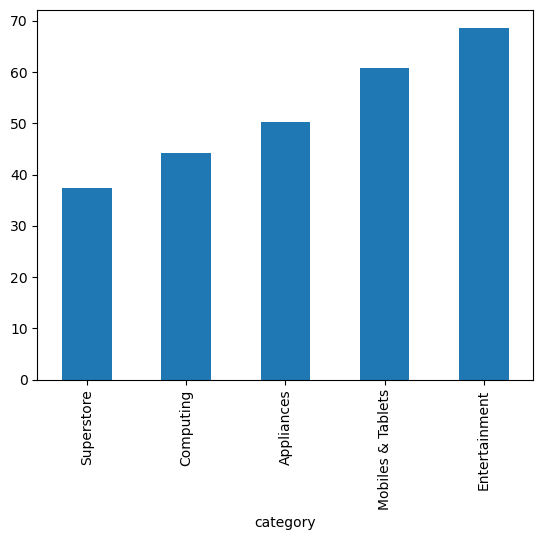

In [44]:
discount_prc_category.sort_values().tail(5).plot(kind='bar')
plt.show()

##### Which age segment spends the most?  

In [45]:
age_group_spending = df.groupby('age_group')['total'].sum()
age_group_spending

age_group
18-24    1.01e+07
25-34    1.46e+07
35-44    1.57e+07
45-54    1.40e+07
55-64    1.50e+07
65-74    1.42e+07
75+      1.52e+06
Name: total, dtype: float64

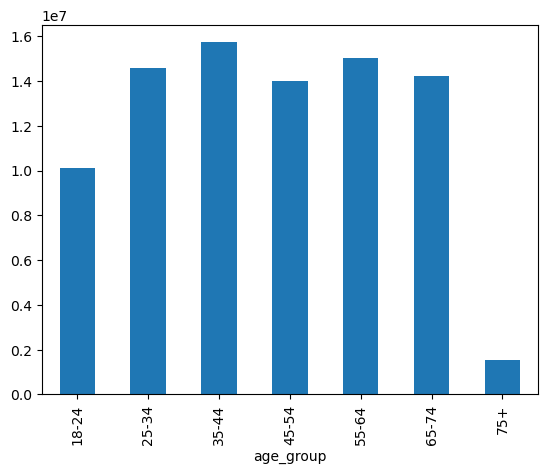

In [46]:
age_group_spending.plot(kind='bar')
plt.show()

We can clearly see that the 35-44 group spends the most

In [47]:
age_group_spending.idxmax()

'35-44'

##### For the category with the highest revenue, plot the revenue per week for CA.  

first we need to detrmine the highest overall revenue category

In [48]:
highest_revenue_category = df.groupby('category')['total'].sum().idxmax()

Then we want to create a week column in our dataframe

In [49]:
df['order_week'] = df['order_date'].dt.isocalendar().week

Now we can create our series that has weeks as indices and total sales of the highest-revenue category products in CA

In [50]:
revenue_per_week_ca_highest_cat = df[(df['State'] == 'CA') & (df['category'] == highest_revenue_category)].sort_values('order_week').groupby('order_week')['total'].sum()

And now for the plot, I am opting for a line graph because it is a time Series.  

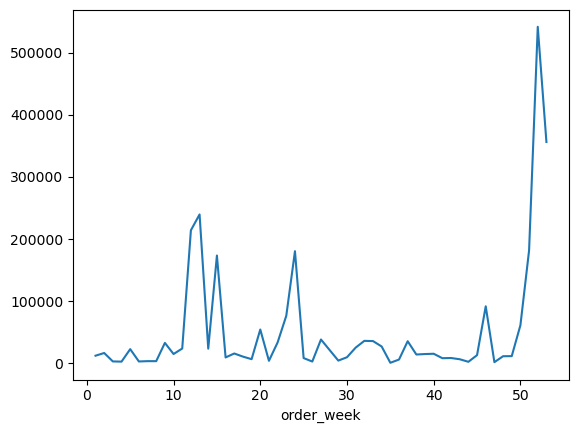

In [51]:
revenue_per_week_ca_highest_cat.plot(kind='line')
plt.show()

##### What is the average item count per order in each category?  

In [71]:
df.groupby(['category', 'order_id'])['qty_ordered'].sum().groupby('category').mean()
# The first part is about summing up all quantities of a given category inside an order (e.g. 2 Iphones and 1 Tablet)
# Having found the total quantity, per order, per category, we can now take the average quantity for each category
# Seems to be different than what the solution got. I do not understand what the solution is trying to achieve.

category
Appliances             2.97
Beauty & Grooming      6.64
Books                  3.02
Computing              3.09
Entertainment          2.06
Health & Sports        6.29
Home & Living          5.44
Kids & Baby            5.68
Men's Fashion          3.89
Mobiles & Tablets      2.39
Others                 4.33
School & Education     5.91
Soghaat                8.12
Superstore            12.68
Women's Fashion        4.83
Name: qty_ordered, dtype: float64

##### Which two days of the week have the highest number of transactions?  

First we need to create a column with the weekday, derived from the order_date

In [78]:
df['week_day'] = df['order_date'].dt.strftime('%A')

now I am counting the orders of each week

In [79]:
week_day_transactions = df.groupby('week_day')['order_id'].count()
week_day_transactions

week_day
Friday       17723
Monday       19489
Saturday     18683
Sunday       35914
Thursday     18846
Tuesday      15698
Wednesday    18340
Name: order_id, dtype: int64

Finally I sort the series in a descending order and pick the top two transanction days

In [80]:
week_day_transactions.sort_values(ascending=False).head(2)

week_day
Sunday    35914
Monday    19489
Name: order_id, dtype: int64

It is Sunday and Monday, as derived from the dt function.

##### If you wanted to launch an effective marketing campaign, in which category, age, gender, time of the year and days of the week would be to maximize its efficiency? Are you considering offering products at a discount and why?

To answer this I could separately group by each of the aforementioned fields, and find the max revenue index for each.  
Having said that, it seems to me,  that I would get a more precise result, if I were to group by the combination of all of the above, including the `is_discounted` boolean field

In [81]:
df.groupby(['category', 'age_group', 'Gender', 'order_month', 'week_day', 'is_discounted'])['total'].sum().idxmax()

('Mobiles & Tablets', '25-34', 'M', 12, 'Sunday', True)

So, according to my analysis, an effective marketing campaign, would involve promoting products in the Mobiles & Tablets category on a December Sunday, targeting males of the age group of 25-34, and offering a discount. I would argue though, that discount benefits cannot be correctly assessed without taking into consideration the cost of the products. As an extreme example, just to showcase this, imagine we discounted a product down to its cost, and then sold insane amounts of it... The revenue would probably beat the non-discount (or light-discount) revenue, but the profit would be zero. With that into consideration, and the fact that we do not have access to costs in out datasets, I will also explore the behavior of sales, when no discount is offered.

In [82]:
df[df['is_discounted'] == False].groupby(['category', 'age_group', 'Gender', 'order_month', 'week_day'])['total'].sum().idxmax()

('Others', '55-64', 'F', 4, 'Saturday')

This yields another result ('Others', '55-64', 'F', 4, 'Saturday'), and it might be a better indicator, but still, not as good as if we had access to the profit per sale.